In [7]:
import os, sys

os.chdir('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
# ^ just a sanity thing: console starts from project root, but pycharm 'run in console' runs with 'model_build' as working directory

import OFM_model as ofm
import OFM_sensitivity as ofms
import pandas as pd
import numpy as np
# import itertools
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.colors import TwoSlopeNorm
# import cmasher as cmr
# import colorcet as cet
from importlib import reload  ## for reloading packages
import scipy
# import pickle

In [2]:
# reload(ofm)
# test_i_flights = pd.Series(np.arange(0, 20))
# test_i_nonflights = pd.Series([1]*20)
# test_i_other = pd.Series({5:1})
# test_i_blank = pd.Series(dtype='float64')
#
# test_model = ofm.ISIRmodel_SingleRun(
#     R_zero=1,
#     t_incubation=1,
#     func_infectious=[0,0,0],
#     pop_total=100,
#     sim_time=100,
#     imports_flights=test_i_flights,
#     imports_indirect=test_i_nonflights,
#     imports_other=test_i_other,
#     flightban_on=10,
# )

In [18]:
imports_path = "data_input/infectious_func_rw_rev3.pickletable"

imports_df = pd.read_pickle(imports_path)

In [19]:
ref_day = imports_df.loc[imports_df['date'] == '2021-11-26', :].index[0]

In [53]:

p_flightbans = range(-7, 57, 1)  # 1-day increments since -7 (week earlier) till 56 days
s_flightbans = range(-3, 4, 1)
R_range = list(np.arange(11, 31, 1) / 10)

model_vers = 'v5.2b'
pop_NL = int(17.48e6)  # 17.48 million

# generate infectious distribution for v2
available_distributions = {
    'alpha': (2.0, 0.44),
    'delta': (2.11, 0.50),
    'omicron': (2.14, 0.59)
}
a = 2.14
rate = .59
x = range(0, 20, 1)
func_serial = scipy.stats.gamma.pdf(x=x, a=a, scale=1 / rate, loc=-1)
func_serial_cdf = scipy.stats.gamma.cdf(x=x, a=a, scale=1 / rate, loc=-1)  # for illustration
# design a cutoff
# Note: truncation of day 0 entry


In [21]:
test_i_nonflights = pd.Series([1] * 20)
test_i_other = pd.Series({5: 100})
test_i_blank = pd.Series(dtype='float64')

In [37]:
reload(ofm)
# np.seterr(all='raise')
experiments = ofm.ISIR_PolicyExperiments(
    u_ImportsFunc=imports_df['infect_presence'],
    p_FlightBans=(-7, 0, 7),
    u_ImportsIndirect=(0.1, 0.2, 0.3),
    u_Rzero=(1.3,),
    u_ImportsFlights=(14, 15, 20),
    u_Func_Infectious=(func_serial,),
    c_SimTime=300,
    c_import_scaling_mode=2,  # **
    c_model_engine='step_v2_variable_beta',
    s_indirect_import_mode=2,
    c_nominal_ref_date=ref_day,
    # s_starting_S_size = (0.5,),
    debug_mode=False,
    sim_mode=True,
)

In [38]:

# experiments.run_experiments()
# experiments.run_experiments_multiprocess(n_workers=5)
# debuggo = experiments.debug_experiment  # don't forget to turn on debug_mode in Experiment definition

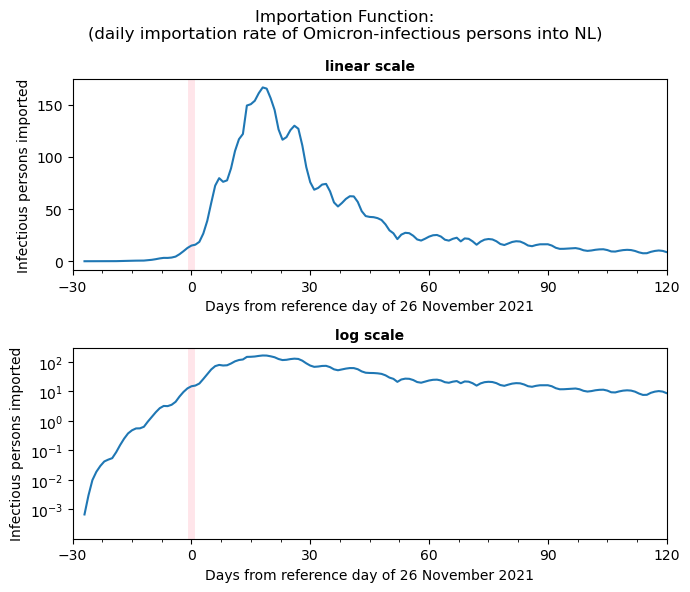

In [90]:
# Make plot for import function

plot_data = experiments.i_flights_scaled[15]
plot_axis = imports_df['day_rel']

fig, ax = plt.subplots(figsize=(7, 6), nrows=2)
for vers, draw_ax in [('linear', 0), ('log', 1)]:
    curr_ax = ax[draw_ax]
    sns.lineplot(
        y=plot_data,
        x=plot_axis,
        ax = curr_ax)

    curr_ax.set_xlim(-30, 120)
    curr_ax.set_xticks(np.arange(-300, 1210, 75)/10, minor=True)
    curr_ax.set_xticks(range(-30, 121, 30))

    curr_ax.set_xlabel("Days from reference day of 26 November 2021")
    curr_ax.set_ylabel("Infectious persons imported")
    curr_ax.axvline(0, c='pink', zorder=0.8, linewidth=5, alpha=0.4)
    curr_ax.set_title(f'{vers} scale', fontsize=10, fontweight='bold')
    if vers == 'log':
        curr_ax.set_yscale('log')
        curr_ax.set_ylim(0.0001, None)
        curr_ax.set_yticks([0.001, 0.01, 0.1, 1, 10, 100])

fig.suptitle("Importation Function:\n"
                 "(daily importation rate of Omicron-infectious persons into NL)")
plt.tight_layout()
plt.savefig(f"output_figures/{model_vers}/{model_vers}_ImportationFunction.jpg", dpi=300)

In [0]:
experiments.reshape_MP_output(experiments.scenarios, experiments.experiments)
# multirun_results = list(experiments.experiments)

In [32]:
# ad hoc verification
# import_check = pd.concat([imp for _,_, imp in  experiments.experiments], axis=1)

# sensitivity analysis build debug

In [10]:
reload(ofm)  # reload this first because ofms is dependent on this
reload(ofms)

sens_exp = ofms.ISIR_SensitivityExperiments(
    sa_method='sobol',
    n_samples=1024,
    # TODO: incomplete
    u_ImportsFunc=imports_df['infect_pax'],
    p_FlightBans=tuple(range(-2, 15, 1)),
    u_ImportsIndirect=(0., 0.1, 0.2, 0.3),
    u_Rzero=list(np.arange(12, 20, 1) / 10),
    u_ImportsFlights=(15, 30, 45, 60),
    u_Func_Infectious=(func_serial,),
    c_SimTime=120,
    c_import_scaling_mode=2,  # **
    c_model_engine='step_v2_variable_beta',
    s_indirect_import_mode=2,
    # s_starting_S_size = (0.5,),
    debug_mode=False,
    sim_mode=True,
)

In [11]:
sens_exp.ISIR_evaluate_mp(n_workers=6)

OFM_PE: Running MULTIPROCESS mode with 10240 experiments


100%|██████████| 10240/10240 [04:00<00:00, 42.64it/s]


OFM_PE: all experiments completed at 4.01 mins


In [12]:
sens_exp.ISIR_analyse()

<bound method ProblemSpec.analyze of {'names': ['u_Rzero', 'p_FlightBans', 'u_ImportsFlights', 'u_ImportsIndirect'], 'num_vars': 4, 'bounds': array([[ 0,  8],
       [ 0, 17],
       [ 0,  4],
       [ 0,  4]]), 'groups': None, 'outputs': ['days_10k_cumulative', 'days_5k_daily', 'resultant_infected', 'duration', 'peak_day', 'peak_value'], 'dists': None, 'sample_scaled': True}>

In [13]:
print(sens_exp.problem)

Samples:
	4 parameters: ['u_Rzero', 'p_FlightBans', 'u_ImportsFlights', 'u_ImportsIndirect']
	10240 evaluations 

Outputs:
	6 outputs: ['days_10k_cumulative', 'days_5k_daily', 'resultant_infected', 'duration', 'peak_day', 'peak_value']
	10240 evaluations 

Analysis:
days_10k_cumulative:
                         ST   ST_conf
u_Rzero            0.501707  0.108106
p_FlightBans       0.259832  0.070395
u_ImportsFlights   0.219827  0.039397
u_ImportsIndirect  0.307815  0.099807 

                         S1   S1_conf
u_Rzero            0.334940  0.079628
p_FlightBans       0.121054  0.034046
u_ImportsFlights   0.198283  0.044832
u_ImportsIndirect  0.128408  0.061497 

                                             S2   S2_conf
(u_Rzero, p_FlightBans)                0.034820  0.113744
(u_Rzero, u_ImportsFlights)           -0.006205  0.095112
(u_Rzero, u_ImportsIndirect)           0.054158  0.109152
(p_FlightBans, u_ImportsFlights)       0.005277  0.055113
(p_FlightBans, u_ImportsIndirect)     

In [0]:
a1 = pd.DataFrame.from_dict(dict(sens_exp.experiments), orient='index')
a2 = a1.to_numpy()
sens_exp.problem['outputs'] = a1.columns.tolist()

In [27]:
sens_exp.problem.set_results(a2)
sens_exp.problem.analyze(sens_exp._analyser)


{'names': ['u_ImportsFlights', 'u_Rzero', 'u_ImportsIndirect', 'p_FlightBans'],
 'num_vars': 4,
 'bounds': array([[0, 4],
        [0, 4],
        [0, 4],
        [0, 4]]),
 'groups': None,
 'outputs': ['days_10k_cumulative',
  'days_5k_daily',
  'resultant_infected',
  'duration',
  'peak_day',
  'peak_value'],
 'dists': None,
 'sample_scaled': True}

In [31]:
pd.DataFrame.from_dict(sens_exp.problem.analysis)
# need to break out the individual items per output

,days_10k_cumulative,days_5k_daily,resultant_infected,duration,peak_day,peak_value
S1,"[0.10222674726128124, 0.3141273961559589, 0.18...","[0.040681826306311904, 0.3810471340838643, 0.2...","[-0.001755913385446413, 0.9417176977646745, 0....","[-0.0031640286642646014, 0.6160236672462538, 0...","[0.03257522202708029, 0.8184853786696201, 0.09...","[-0.0005299356925107786, 1.0043473363899682, -..."
S1_conf,"[0.10703464184579206, 0.13149901664901067, 0.1...","[0.10748675669217123, 0.16624342173382226, 0.1...","[0.02204898183793534, 0.35316794331978635, 0.0...","[0.05100429909399256, 0.3266996511838595, 0.16...","[0.08964271332162595, 0.26011686142164114, 0.1...","[0.004914298635689227, 0.2843796367915384, 0.0..."
ST,"[0.1254944165706115, 0.4537105829860569, 0.380...","[0.10121701783469284, 0.5952288352729731, 0.48...","[0.006179944219319035, 1.046990209257154, 0.07...","[0.03449486898568997, 0.9689268067246103, 0.20...","[0.05791286051271614, 0.8327462935689894, 0.20...","[0.00020333789723037257, 1.001186242344622, 0...."
ST_conf,"[0.0924199220982782, 0.3692477874625456, 0.268...","[0.07875625678084436, 0.4780769273169466, 0.33...","[0.005501220553014215, 0.3904050299272703, 0.0...","[0.017076540054664618, 0.3102497066175255, 0.1...","[0.02788801174982767, 0.24711414524570544, 0.1...","[0.00010233445909333259, 0.24788462326978705, ..."
S2,"[[nan, 0.028817568566062046, 0.019164151906784...","[[nan, 0.058893378177406364, 0.044008522613480...","[[nan, 0.024767091295604504, 0.009577852554049...","[[nan, 0.029114341090355822, 0.005318158869351...","[[nan, -0.00802397922630127, 0.012987212973750...","[[nan, 0.003878447781845651, 0.001798377788299..."
S2_conf,"[[nan, 0.14771163455513397, 0.1486053241944691...","[[nan, 0.16720477189237293, 0.1668816428882461...","[[nan, 0.05658857159029375, 0.0396293052607296...","[[nan, 0.09506226162847561, 0.1040670182539510...","[[nan, 0.17269082059046392, 0.0984644644428569...","[[nan, 0.011351396391226017, 0.008223195429339..."


In [34]:
print(sens_exp.problem)

Samples:
	4 parameters: ['u_ImportsFlights', 'u_Rzero', 'u_ImportsIndirect', 'p_FlightBans']
	640 evaluations 

Outputs:
	6 outputs: ['days_10k_cumulative', 'days_5k_daily', 'resultant_infected', 'duration', 'peak_day', 'peak_value']
	640 evaluations 

Analysis:
days_10k_cumulative:
                         ST   ST_conf
u_ImportsFlights   0.125494  0.092420
u_Rzero            0.453711  0.369248
u_ImportsIndirect  0.380136  0.268387
p_FlightBans       0.398138  0.246741 

                         S1   S1_conf
u_ImportsFlights   0.102227  0.107035
u_Rzero            0.314127  0.131499
u_ImportsIndirect  0.183581  0.150919
p_FlightBans       0.215341  0.170984 

                                             S2   S2_conf
(u_ImportsFlights, u_Rzero)            0.028818  0.147712
(u_ImportsFlights, u_ImportsIndirect)  0.019164  0.148605
(u_ImportsFlights, p_FlightBans)       0.072649  0.195383
(u_Rzero, u_ImportsIndirect)          -0.081151  0.207560
(u_Rzero, p_FlightBans)               -0.1

# testing SA sampling and discretisation re-read

In [17]:
sens_samples = sens_exp.problem.samples


In [18]:
# read ndarray, get columns that fit?
# input 'names' attribute in problem
# make copy of nd-array? or pass to pd.df due to type casting?
# make list of all scenarios or generator?  think if it could be chunked
#
test = sens_exp.discretise_read_bulk(problem_varnames=sens_exp.problem['names'],
                                     problem_samples=sens_samples)
for col in test.columns:
    ser = test[col]
    print(ser.value_counts())

# seems like the sampling method has issues with 3-category experiments?

0.2    160
0.0    160
0.3    160
0.1    160
Name: u_ImportsIndirect, dtype: int64
10    160
17    160
31    160
24    160
Name: p_FlightBans, dtype: int64
60    160
45    160
30    160
15    160
Name: u_ImportsFlights, dtype: int64
1.9    160
1.5    160
1.7    160
1.3    160
Name: u_Rzero, dtype: int64


# testing post-processing (done)

In [12]:
post_ops = sens_exp.setup_postprocessing()

In [13]:
# run singular experiments
# idx, output, output_post = sens_exp.handle_single_run(idx=None, variables=sens_exp.scenarios[0],
#                            constants=sens_exp.params_const,
#                            post_ops=post_ops)

# move on to multiprocessing
sens_exp.run_experiments_multiprocess(n_workers=4, postprocess_ops=post_ops)



OFM_PE: Running MULTIPROCESS mode with 144 experiments


100%|██████████| 144/144 [00:05<00:00, 25.85it/s]

OFM_PE: all experiments completed at 0.1 mins
